In [2]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [70]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [4]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [5]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [252]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [35]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [36]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

In [301]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [304]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [0, 0, 0, 0, 0],
                            1: [1, 0, 0, 0, 0],
                            2: [0, 1, 0, 0, 0],
                            3: [0, 0, 1, 0, 0]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

In [307]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

# calculate_rule_score(batch)

In [312]:
# G0 = build_G(
#     batch_size = BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM,
# )
# seqs_random_et, seqs_random_ts = generate_sequences_gumbel(4000, G0, BATCH_SIZE, T)

# seqs_random_et_ind = tf.argmax(seqs_random_et, axis=2).numpy().reshape((N_DATA, T, 1))
# seqs_random_ts_ori = apply_mean_std(seqs_random_ts, GLOBAL_MEAN, GLOBAL_STD)

# batch_for_rules = np.dstack((seqs_random_et_ind, seqs_random_ts_ori))

In [313]:
# _fid_score = calculate_FID_score( seqs_random_ts_ori)
# _mad_score = calculate_MAD_score(seqs_random_et_ind)
# _rule_score = calculate_rule_score(batch_for_rules)

# _fid_score, _mad_score, _rule_score 
# # (10892.375979306666, 0.5591, 0.09175)

## Create multitype SeqGan

In [132]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [133]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [134]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
        
#     return generator

In [135]:
# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [136]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [166]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
    # LSTM-token
    G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    # LSTM-time
    G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [167]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [168]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [169]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [170]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
token ce loss:1.3665122525853537
time mae loss:0.9825561817278105
train loss:2.349068434313164


1it [00:00,  1.33it/s]

Training Step: 2
token ce loss:1.3544096456090144
time mae loss:0.8063611720088131
train loss:2.1607708176178275


2it [00:01,  1.37it/s]

Training Step: 3
token ce loss:1.3458934800397149
time mae loss:0.8137213593020988
train loss:2.1596148393418138


3it [00:02,  1.39it/s]

Training Step: 4
token ce loss:1.344534825622582
time mae loss:0.8381571202623611
train loss:2.182691945884943


4it [00:02,  1.39it/s]

Training Step: 5
token ce loss:1.341913105511982
time mae loss:0.8466005643249317
train loss:2.1885136698369134


5it [00:03,  1.40it/s]

Training Step: 6
token ce loss:1.334582510281924
time mae loss:0.7954178453035401
train loss:2.130000355585464


6it [00:04,  1.40it/s]

Training Step: 7
token ce loss:1.3368331005319318
time mae loss:0.7838479480438852
train loss:2.120681048575817


7it [00:05,  1.39it/s]

Training Step: 8
token ce loss:1.3345597220877117
time mae loss:0.7788890246158866
train loss:2.1134487467035985


8it [00:05,  1.40it/s]

Training Step: 9
token ce loss:1.328734849336774
time mae loss:0.7809721167757778
train loss:2.109706966112552


9it [00:06,  1.40it/s]

Training Step: 10
token ce loss:1.3292138511120524
time mae loss:0.7957179209196834
train loss:2.1249317720317356


10it [00:07,  1.40it/s]

Training Step: 11
token ce loss:1.3246692894176992
time mae loss:0.8018837272788174
train loss:2.1265530166965165


11it [00:07,  1.40it/s]

Training Step: 12
token ce loss:1.325069759250975
time mae loss:0.7892331800225935
train loss:2.1143029392735686


12it [00:08,  1.40it/s]

Training Step: 13
token ce loss:1.324512292311189
time mae loss:0.7942727989181566
train loss:2.1187850912293458


13it [00:09,  1.40it/s]

Training Step: 14
token ce loss:1.313957924198336
time mae loss:0.774987369858881
train loss:2.0889452940572166


14it [00:10,  1.40it/s]

Training Step: 15
token ce loss:1.3180749304182238
time mae loss:0.7846279398835797
train loss:2.1027028703018034


15it [00:10,  1.40it/s]

Training Step: 16
token ce loss:1.3172884816447876
time mae loss:0.7854540142044464
train loss:2.102742495849234


16it [00:11,  1.40it/s]

Training Step: 17
token ce loss:1.3131537312978638
time mae loss:0.7936447049644757
train loss:2.1067984362623395


17it [00:12,  1.40it/s]

Training Step: 18
token ce loss:1.3205358536243714
time mae loss:0.7774952716027389
train loss:2.09803112522711


18it [00:12,  1.40it/s]

Training Step: 19
token ce loss:1.3064883447922682
time mae loss:0.792162380120011
train loss:2.098650724912279


19it [00:13,  1.40it/s]

Training Step: 20
token ce loss:1.3119943102313907
time mae loss:0.7818892901835631
train loss:2.0938836004149537


20it [00:14,  1.40it/s]

Training Step: 21
token ce loss:1.3119602677310234
time mae loss:0.7733832082283695
train loss:2.0853434759593927


21it [00:15,  1.39it/s]

Training Step: 22
token ce loss:1.303070089057539
time mae loss:0.7716439010457891
train loss:2.0747139901033282


22it [00:15,  1.28it/s]

Training Step: 23
token ce loss:1.299715255453192
time mae loss:0.7864828740339753
train loss:2.086198129487167


23it [00:16,  1.31it/s]

Training Step: 24
token ce loss:1.2994209434090804
time mae loss:0.768774076655522
train loss:2.0681950200646027


24it [00:17,  1.33it/s]

Training Step: 25
token ce loss:1.296631182394224
time mae loss:0.7681625678349349
train loss:2.0647937502291587


25it [00:18,  1.35it/s]

Training Step: 26
token ce loss:1.3007441650359843
time mae loss:0.7898317533145824
train loss:2.0905759183505666


26it [00:18,  1.36it/s]

Training Step: 27
token ce loss:1.302403425798669
time mae loss:0.7976874469079858
train loss:2.1000908727066547


27it [00:19,  1.37it/s]

Training Step: 28
token ce loss:1.3052267209810386
time mae loss:0.7849078045913066
train loss:2.090134525572345


28it [00:20,  1.37it/s]

Training Step: 29
token ce loss:1.3019957598702425
time mae loss:0.7780523743032509
train loss:2.0800481341734933


29it [00:21,  1.38it/s]

Training Step: 30
token ce loss:1.2975384550720335
time mae loss:0.782877147724764
train loss:2.0804156027967977


30it [00:21,  1.38it/s]

Training Step: 31
token ce loss:1.300135803970427
time mae loss:0.7932214809536726
train loss:2.0933572849240996


31it [00:22,  1.39it/s]

Training Step: 32
token ce loss:1.2914568680011542
time mae loss:0.7835128739362305
train loss:2.0749697419373847


32it [00:23,  1.38it/s]

Training Step: 33
token ce loss:1.2922414832420204
time mae loss:0.770444091083045
train loss:2.0626855743250654


33it [00:23,  1.39it/s]

Training Step: 34
token ce loss:1.2927068790439413
time mae loss:0.7742690981470347
train loss:2.066975977190976


34it [00:24,  1.38it/s]

Training Step: 35
token ce loss:1.2954118674733943
time mae loss:0.7961601977297628
train loss:2.091572065203157


35it [00:25,  1.38it/s]

Training Step: 36
token ce loss:1.289402473784966
time mae loss:0.7880269904945091
train loss:2.0774294642794753


36it [00:26,  1.38it/s]

Training Step: 37
token ce loss:1.2940931964610243
time mae loss:0.7768815636652322
train loss:2.0709747601262567


37it [00:26,  1.39it/s]

Training Step: 38
token ce loss:1.2967598171653207
time mae loss:0.7874779219235298
train loss:2.0842377390888505


38it [00:27,  1.39it/s]

Training Step: 39
token ce loss:1.2922628051599805
time mae loss:0.7814043867848512
train loss:2.073667191944832


39it [00:28,  1.39it/s]

Training Step: 40
token ce loss:1.2892943857871249
time mae loss:0.7878142658531125
train loss:2.0771086516402373


40it [00:28,  1.39it/s]

Training Step: 41
token ce loss:1.285608971096076
time mae loss:0.7797365869085534
train loss:2.0653455580046294


41it [00:29,  1.39it/s]

Training Step: 42
token ce loss:1.2825305275389705
time mae loss:0.7743367959941986
train loss:2.056867323533169


42it [00:30,  1.39it/s]

Training Step: 43
token ce loss:1.2802903977261901
time mae loss:0.7748005963365934
train loss:2.0550909940627835


43it [00:31,  1.39it/s]

Training Step: 44
token ce loss:1.282605639805342
time mae loss:0.7770353407281777
train loss:2.0596409805335196


44it [00:31,  1.39it/s]

Training Step: 45
token ce loss:1.2833405551599042
time mae loss:0.7734974945605567
train loss:2.056838049720461


45it [00:32,  1.39it/s]

Training Step: 46
token ce loss:1.2837239313816788
time mae loss:0.7805384985147882
train loss:2.064262429896467


46it [00:33,  1.38it/s]


In [171]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [172]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_35 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

### pre-train D

In [173]:
N_fake_D = N_real_D = N_total_G 

In [174]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [175]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [192]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [193]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [194]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 10

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
total discriminator loss:0.693771277091829


1it [00:00,  2.41it/s]

Training Step: 2
total discriminator loss:0.6857820368399947


2it [00:00,  2.54it/s]

Training Step: 3
total discriminator loss:0.6559617537850566


3it [00:01,  2.59it/s]

Training Step: 4
total discriminator loss:0.6439796495181203


4it [00:01,  2.61it/s]

Training Step: 5
total discriminator loss:0.6223149688587302


5it [00:01,  2.61it/s]

Training Step: 6
total discriminator loss:0.6024451363349796


6it [00:02,  2.62it/s]

Training Step: 7
total discriminator loss:0.5791255147624835


7it [00:02,  2.63it/s]

Training Step: 8
total discriminator loss:0.5236926745119641


8it [00:03,  2.63it/s]

Training Step: 9
total discriminator loss:0.5093087091625654


9it [00:03,  2.64it/s]

Training Step: 10
total discriminator loss:0.46957905419817836


10it [00:03,  2.61it/s]


In [195]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [196]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_44 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

## Gumbel  Traning

In [314]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [325]:
def track_training(step, G, save_path=None, verbose=True, plot=True):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path:
        print('Saving weights...')            
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)

        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        print('All Saved!')
        
    return _mad_score, _fid_score, _rule_score

In [326]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_70 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [327]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []
mad_history = []
fid_history = []
rule_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
model_save_path = os.path.join(model_save_dir, now_str)
print(model_save_path)
print(_TOTAL_STEPS)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-08-53-05
1562


0it [00:00, ?it/s]

Training Step: 0
event_types: [[2], [1], [2], [0], [2], [2], [3], [0], [1], [2], [2], [3], [1], [0], [2], [2], [1], [0], [1], [2]]
mad_score: 0.4341
fid_score: 9745.169700578004
rule_score: 0.51975


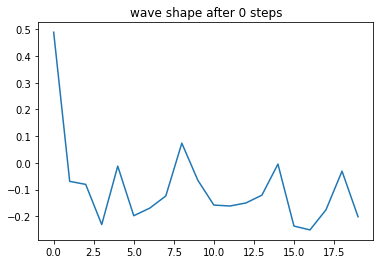

Saving weights...
G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-08-53-05/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-08-53-05/D_0/model_weights.tf
All Saved!
generator loss:1.0734462532860858
-----------------------


1it [00:11, 11.13s/it]

total discriminator loss:0.567835652004578
average true return:0.5545275038969416
-----------------------
Training Step: 1
generator loss:1.094400965776819
-----------------------


2it [00:13,  5.73s/it]

total discriminator loss:0.5796232537909369
average true return:0.5026571733749226
-----------------------
Training Step: 2
generator loss:1.06846570264973
-----------------------


3it [00:15,  4.00s/it]

total discriminator loss:0.5884736470211256
average true return:0.5149785278547835
-----------------------
Training Step: 3
generator loss:1.0635462788655357
-----------------------


4it [00:16,  3.18s/it]

total discriminator loss:0.5778847367059321
average true return:0.5009732399294917
-----------------------
Training Step: 4
generator loss:1.0477446863487574
-----------------------


5it [00:18,  2.73s/it]

total discriminator loss:0.5906610366698716
average true return:0.49313139313934573
-----------------------
Training Step: 5


5it [00:19,  3.99s/it]


KeyboardInterrupt: 

In [328]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, model_save_path, verbose=True, plot=True)
        mad_history.append(_mad_score)
        fid_history.append(_fid_score)
        rule_history.append(_rule_score)
        
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
                
    step += 1

Text(0.5, 0, 'Training steps')

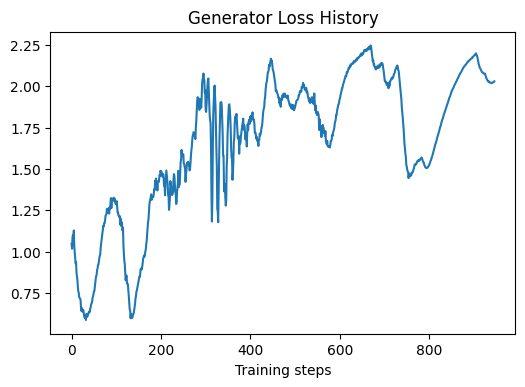

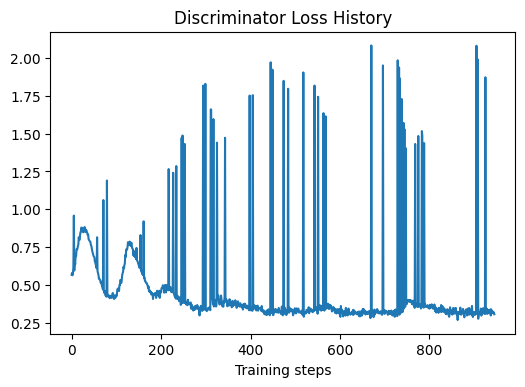

In [203]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

(0.0, 100.0)

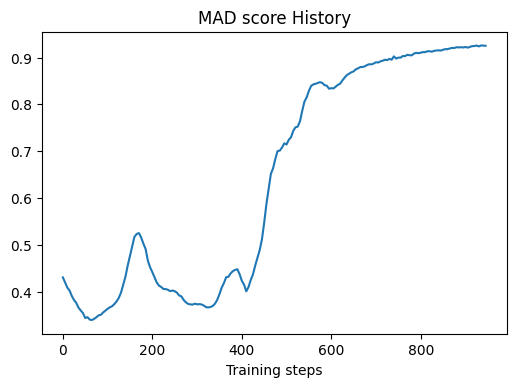

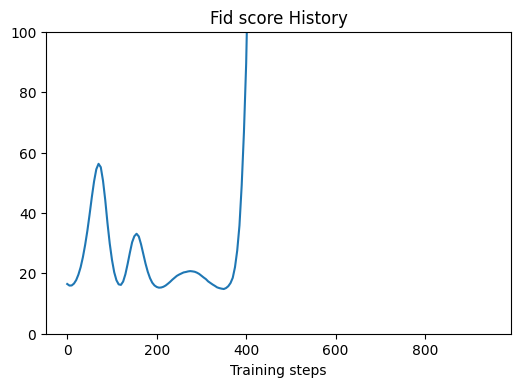

In [207]:
x =  [i * 5 for i in range(len(mad_history))]
plt.figure(dpi=100)
plt.plot(x, mad_history)
plt.title('MAD score History')
plt.xlabel('Training steps')

x =  [i * 5 for i in range(len(fid_history))]
plt.figure(dpi=100)
plt.plot(x, fid_history)
plt.title('Fid score History')
plt.xlabel('Training steps')
plt.ylim([0, 100])

## Compare between G0, G1 and G2

In [80]:
from matplotlib import pyplot as plt

tf.Tensor(
[[1 2 3 ... 1 1 0]
 [2 2 2 ... 1 1 3]
 [3 3 3 ... 2 3 2]
 ...
 [2 2 2 ... 0 0 1]
 [1 1 0 ... 0 1 3]
 [2 0 0 ... 2 1 3]], shape=(4000, 20), dtype=int64)


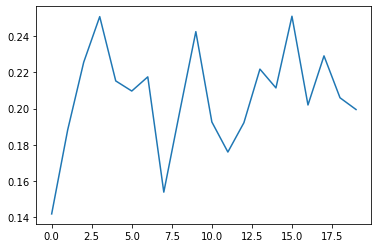

In [62]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(4000, G0, BATCH_SIZE, T)
print(tf.argmax(seqs_random_et, axis=2))

ind = 1
x = np.arange(seqs_random_ts[ind,:,:].shape[0])
y = seqs_random_ts[ind,:,:]

plt.plot(x, y)

In [64]:
seqs_random_ts.shape

TensorShape([4000, 20, 1])

tf.Tensor(
[[0 1 2 3 1 2 2 3 1 3 1 2 1 2 1 0 2 1 3 1]
 [2 1 0 0 1 1 2 2 2 3 3 2 2 1 0 3 1 2 2 1]
 [2 1 1 0 1 1 2 1 3 2 2 2 1 3 3 2 0 2 1 3]
 [0 2 3 1 0 1 1 2 1 0 2 2 0 2 1 3 2 1 0 2]
 [2 2 1 0 2 2 3 3 3 2 3 2 1 0 2 0 2 0 3 1]
 [3 2 2 3 2 1 1 1 2 0 2 1 0 2 1 1 2 2 2 0]
 [3 1 0 1 2 2 3 2 2 0 2 0 2 3 3 1 2 1 2 2]
 [2 2 3 3 1 1 1 2 0 2 2 1 0 0 2 1 0 2 1 1]
 [3 2 2 1 3 2 1 0 2 1 2 0 0 2 3 1 0 2 0 1]
 [2 0 1 2 0 2 2 3 3 1 3 2 1 0 3 2 2 1 3 0]], shape=(10, 20), dtype=int64)


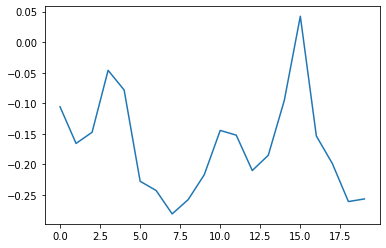

In [82]:
G1 = pretrained_generator
seqs_pretrained_et, seqs_pretrained_ts = generate_sequences_gumbel(10, G1, BATCH_SIZE, T)
print(tf.argmax(seqs_pretrained_et, axis=2))

ind = 1
x = np.arange(seqs_pretrained_ts[ind,:,:].shape[0])
y = seqs_pretrained_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[0 0 2 3 2 1 3 3 3 1 0 1 2 3 0 2 3 1 1 2]
 [2 2 3 3 2 1 0 1 0 1 2 3 0 2 1 3 2 1 1 2]
 [3 0 2 2 0 3 3 2 1 1 2 3 2 0 2 0 2 0 1 3]
 [2 3 3 2 3 0 1 0 2 3 1 0 3 0 1 2 1 3 1 2]
 [3 2 1 0 2 1 1 3 3 2 2 0 3 1 1 0 2 0 1 2]
 [0 1 1 3 2 0 1 0 1 3 2 3 2 0 3 0 1 0 1 1]
 [2 1 0 2 3 2 3 2 0 2 1 3 1 3 2 3 3 2 0 2]
 [1 2 2 2 0 2 2 3 1 2 3 3 3 3 2 0 2 1 3 1]
 [2 3 3 1 3 3 0 2 3 2 1 0 2 2 3 0 1 0 1 2]
 [1 2 2 3 0 0 1 1 3 2 3 1 1 0 1 0 2 2 1 3]], shape=(10, 20), dtype=int64)


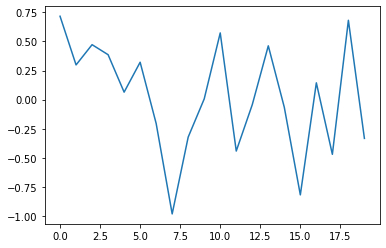

In [155]:
G2 = G
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(10, G2, BATCH_SIZE, T)

print(tf.argmax(seqs_trained_et, axis=2))

ind = 3
x = np.arange(seqs_trained_ts[ind,:,:].shape[0])
y = seqs_trained_ts[ind,:,:]

plt.plot(x, y)

In [156]:
raw_seqs_trained_et_100, raw_seqs_trained_ts_100 = generate_sequences_gumbel(400, G2, BATCH_SIZE, T)

In [158]:
 tf.argmax(raw_seqs_trained_et_100, axis=2)

<tf.Tensor: shape=(400, 20), dtype=int64, numpy=
array([[2, 1, 1, ..., 2, 2, 3],
       [0, 1, 0, ..., 2, 2, 3],
       [0, 0, 2, ..., 2, 1, 2],
       ...,
       [0, 2, 3, ..., 0, 1, 0],
       [0, 1, 3, ..., 2, 1, 3],
       [2, 3, 1, ..., 1, 1, 2]])>

In [160]:
apply_mean_std(raw_seqs_trained_ts_100, *get_mean_std(raw_pos_timestamp_seqs))

<tf.Tensor: shape=(400, 20, 1), dtype=float64, numpy=
array([[[50.18729542],
        [40.7488562 ],
        [20.97730132],
        ...,
        [24.03788532],
        [48.64821627],
        [54.47746862]],

       [[47.54148631],
        [37.34665968],
        [17.52899831],
        ...,
        [36.99412153],
        [42.40066611],
        [47.17425319]],

       [[13.59134064],
        [29.50389021],
        [27.93907203],
        ...,
        [49.44629442],
        [51.59025511],
        [28.84871038]],

       ...,

       [[47.60783842],
        [34.60444999],
        [31.64446635],
        ...,
        [42.89198634],
        [35.84880778],
        [15.26358076]],

       [[47.24778428],
        [34.49610723],
        [14.16845675],
        ...,
        [32.39864934],
        [39.00880497],
        [23.31582317]],

       [[44.30237448],
        [39.07720542],
        [44.35385422],
        ...,
        [40.94073832],
        [26.21884135],
        [25.7710909 ]]])>

## Save trained G and D weights

In [75]:
if not os.path.exists(model_save_dir + '/G_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/G_run_syn_v11_200')

G_save_path = model_save_dir + '/G_run_syn_v11_200/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/D_run_syn_v11_200')

D_save_path = model_save_dir + '/D_run_syn_v11_200/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Generate Synthesized data

In [87]:
G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/G_run_syn_v11_200/model.tf'

In [88]:
G_200 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G_200.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_16 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [164]:
G_100 = G2
raw_seqs_trained_et_100, raw_seqs_trained_ts_100 = generate_sequences_gumbel(400000, G_100, BATCH_SIZE, T)

In [165]:
seqs_save_et_100 = tf.argmax(raw_seqs_trained_et_100[:400000, :, :], axis=2)
seqs_save_ts_100 = apply_mean_std(raw_seqs_trained_ts_100[:400000, :, :], *get_mean_std(raw_pos_timestamp_seqs))

In [169]:
import pickle

pos_seqs_filename_et = 'syn_positive_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_positive_time_sequences.pickle'

repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"

with open(os.path.join(repo_path, 'syn_data', 'gumbel_softmax_100it', pos_seqs_filename_et), 'wb') as f:
    pickle.dump(seqs_save_et_100, f)
    
with open(os.path.join(repo_path, 'syn_data', 'gumbel_softmax_100it', pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(seqs_save_ts_100, f)

In [161]:
seqs_save_et_100[:10]

<tf.Tensor: shape=(10, 20), dtype=int64, numpy=
array([[2, 3, 1, 2, 3, 3, 1, 0, 2, 0, 2, 3, 2, 2, 2, 0, 0, 2, 1, 3],
       [1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 3, 2, 0, 0, 1, 3, 0, 3, 1],
       [2, 0, 3, 3, 2, 0, 3, 1, 3, 0, 0, 0, 2, 3, 0, 3, 0, 1, 0, 1],
       [1, 3, 3, 2, 3, 3, 1, 3, 2, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1],
       [2, 1, 3, 1, 2, 0, 1, 0, 0, 1, 3, 3, 0, 0, 3, 0, 2, 0, 0, 1],
       [3, 1, 3, 3, 0, 3, 1, 1, 3, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1],
       [0, 1, 2, 1, 0, 1, 0, 2, 3, 0, 0, 0, 3, 1, 1, 0, 2, 0, 1, 0],
       [3, 2, 1, 1, 3, 3, 1, 3, 1, 3, 1, 0, 0, 0, 2, 1, 2, 3, 0, 1],
       [0, 3, 3, 1, 1, 0, 2, 2, 3, 3, 1, 0, 3, 1, 3, 2, 1, 3, 2, 2],
       [0, 1, 1, 2, 0, 3, 3, 0, 0, 3, 1, 1, 2, 3, 1, 0, 0, 3, 3, 0]])>

In [162]:
seqs_save_ts_100[:10]

<tf.Tensor: shape=(10, 20, 1), dtype=float64, numpy=
array([[[26.28347012],
        [30.71878761],
        [32.31629063],
        [33.14737885],
        [33.66082748],
        [35.05677763],
        [36.41802661],
        [35.58768993],
        [37.22724401],
        [36.85090879],
        [37.61664908],
        [37.76648525],
        [37.89271309],
        [36.70663829],
        [35.58097335],
        [33.90315138],
        [35.39667259],
        [36.21181891],
        [36.51476279],
        [34.62221017]],

       [[26.13454261],
        [30.35504255],
        [32.79624872],
        [35.03936894],
        [36.18738845],
        [37.3220686 ],
        [37.10721951],
        [37.4181661 ],
        [37.83315744],
        [36.28871581],
        [35.8244918 ],
        [36.46416446],
        [37.61382136],
        [36.7705122 ],
        [36.73860961],
        [36.53310435],
        [36.45036593],
        [36.11615577],
        [36.26013271],
        [35.71212021]],

       [[27.03273846],
